In [1]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id, dtype=torch.float32)
# pipe = pipe.to(device)

# prompt = "an astronaut riding a horse"
# image = pipe(prompt).images[0]  
    
# image.save("astronaut_rides_horse.png")

Keyword arguments {'dtype': torch.float32} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
torch.seed()

13397347343052547530

In [3]:
# from diffusers import DiffusionPipeline
# import torch

# pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16)
# pipeline.to("cuda")
# im = pipeline("An image of a squirrel in Picasso style").images[0]
# im

In [5]:
# import numpy as np
# # plt.imshow(np.array(im)/ 255)


# plt.hist((np.array(im)/ 255).ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')

In [6]:
# from diffusers import DiffusionPipeline
# import torch

# torch.manual_seed(4982774180987145168)
# pipeline = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
# pipeline.to("cuda")
# pipeline("a futuristic cityscape").images[0]

In [7]:
from diffusers import PNDMScheduler


pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    dtype=torch.float16,
)
scheduler = pipe.scheduler
model = pipe.unet.to("cuda")
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder.to("cuda")
vae = pipe.vae.to("cuda")
scale_vae_factor = pipe.vae_scale_factor

postprocessor = pipe.image_processor.postprocess


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
scheduler.set_timesteps(50)

In [18]:
prompt = ["a photograph of an astronaut riding a horse"]
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

In [19]:
model.config.sample_size

64

In [22]:
pipe.scheduler.init_noise_sigma

1.0

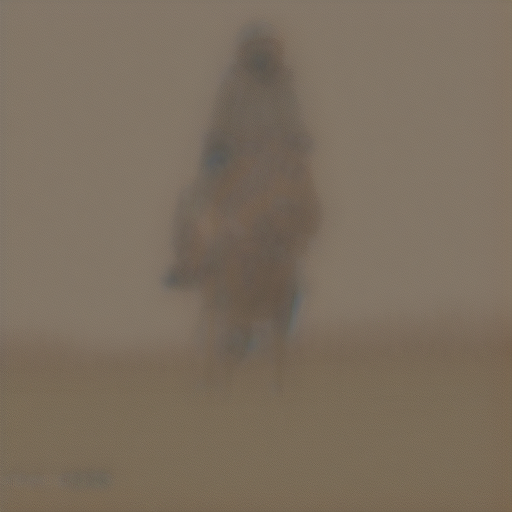

In [23]:
sample_size = model.config.sample_size
# sample_size = 256
# pipe.vae.config.latent_channels in this case is 4
noise = torch.randn((1, pipe.vae.config.latent_channels, sample_size, sample_size), device="cuda") * pipe.scheduler.init_noise_sigma
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t, encoder_hidden_states=text_embeddings).sample        
        prev_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
        input = prev_noisy_sample


final_image = vae.decode(input).sample
image = (final_image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [ ]:
final_image.min()

np.float32(0.0)

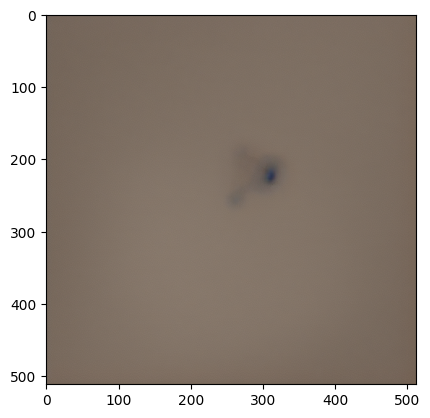

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[0])

(array([131243.,   3001.,   2974.,   2973.,   2996.,   3083.,   3031.,
          3027.,   2979.,   3066.,   3008.,   3094.,   3079.,   3123.,
          3067.,   3138.,   3080.,   3109.,   3244.,   3131.,   3238.,
          3316.,   3355.,   3321.,   3371.,   3290.,   3328.,   3258.,
          3368.,   3366.,   3387.,   3385.,   3354.,   3256.,   3309.,
          3245.,   3242.,   3243.,   3272.,   3288.,   3285.,   3245.,
          3250.,   3326.,   3300.,   3250.,   3191.,   3212.,   3137.,
          3191.,   3092.,   3184.,   3155.,   3111.,   3124.,   3113.,
          3114.,   3063.,   3059.,   3056.,   2989.,   3087.,   2992.,
          2989.,   3065.,   2973.,   2920.,   2935.,   2931.,   3019.,
          2899.,   2917.,   2904.,   2900.,   2974.,   2922.,   2864.,
          2871.,   2865.,   2930.,   2889.,   2822.,   2819.,   2828.,
          2842.,   2821.,   2770.,   2759.,   2785.,   2767.,   2757.,
          2802.,   2828.,   2715.,   2801.,   2837.,   2627.,   2760.,
      

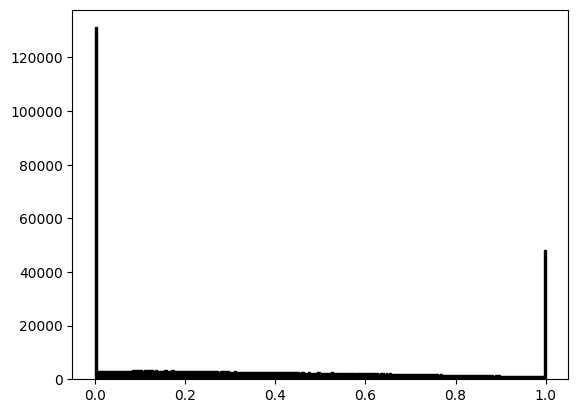

In [ ]:
plt.hist(final_image[0].ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')